In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim

# TensorFlow 내장 MNIST 데이터셋 모듈
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
lr = 0.0002       # leraning rate
beta1 = 0.5       # Adam Optimizer에 사용되는 하이퍼 파라미터 (0.5는 DCGAN 논문의 제안값)
batch_size = 128

sample_dir = "sample/"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
@slim.add_arg_scope
def lrelu(inputs, leak=0.2, scope="lrelu"):
    """discriminator에 사용할 활성 함수"""
    with tf.variable_scope(scope):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * inputs + f2 * abs(inputs)

def generate_z(batch_size, z_dim):
    """랜덤한 노이즈 z를 생성"""
    return np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)

def batch_norm_params(is_training):
    return {
        "decay": 0.9,
        "epsilon": 1e-5,
        "scale": True,
        "updates_collections": None,
        "is_training": is_training
    }

In [4]:
def gen_arg_scope(is_training):
    with slim.arg_scope([slim.conv2d_transpose],
        weights_initializer=slim.variance_scaling_initializer(),
        activation_fn=tf.nn.relu,
        normalizer_fn=slim.batch_norm,
        normalizer_params=batch_norm_params(is_training),
        kernel_size=[4, 4], stride=2, padding="SAME") as arg_scp:
        return arg_scp

def generator(z, scope="generator"):
    with tf.variable_scope(scope) as scp:
        end_pts_collection = scp.name+"_end_pts"
        with slim.arg_scope([slim.conv2d_transpose, slim.fully_connected],
                            outputs_collections=end_pts_collection):
            inputs = tf.reshape(z, (-1, 1, 1, 100))
            net = slim.conv2d_transpose(inputs, 128, 
                                        kernel_size=[7, 7], stride=1, padding="VALID", 
                                        scope="projection")
            net = slim.conv2d_transpose(net, 64, scope="conv_tp_1")
            net = slim.conv2d_transpose(net, 1, 
                                        activation_fn=tf.nn.tanh,
                                        normalizer_fn=None,
                                        normalizer_params=None,
                                        scope="conv_tp_2")
            end_pts = slim.utils.convert_collection_to_dict(end_pts_collection)
    return net, end_pts

In [5]:
def disc_arg_scope(is_training):
    with slim.arg_scope([slim.conv2d],
        weights_initializer=slim.variance_scaling_initializer(),
        activation_fn=lrelu,
        normalizer_fn=slim.batch_norm,
        normalizer_params=batch_norm_params(is_training),
        kernel_size=[4, 4], stride=2, padding="SAME") as arg_scp:
        return arg_scp

def discriminator(inputs, reuse=None, scope="discriminator"):
    with tf.variable_scope(scope, reuse=reuse) as scp:
        end_pts_collection = scp.name+"end_pts"
        with slim.arg_scope([slim.conv2d],
                            outputs_collections=end_pts_collection):
            net = slim.conv2d(inputs, 32, scope="conv1")
            net = slim.conv2d(net, 64, scope="conv2")
            net = tf.reduce_mean(net, [1, 2], keep_dims=True, name="pool")
            net = slim.conv2d(net, 1, 
                              kernel_size=[1, 1], stride=1, padding="VALID", 
                              activation_fn=None,
                              normalizer_fn=None,
                              normalizer_params=None,
                              scope="logit")

            end_pts = slim.utils.convert_collection_to_dict(end_pts_collection)
            net = tf.squeeze(net, [1, 2], name="squeeze")
    return net, end_pts

In [6]:
z_ = tf.placeholder(tf.float32, [None, 100])
X_ = tf.placeholder(tf.float32, [None, 28, 28, 1])
is_training = tf.placeholder(tf.bool)

# generator 생성
with slim.arg_scope(gen_arg_scope(is_training)):
    G, G_end_pts = generator(z_)

# discriminator 생성
with slim.arg_scope(disc_arg_scope(is_training)):
    D_real, D_real_end_pts = discriminator(X_)
    D_fake, D_fake_end_pts = discriminator(G, reuse=True)
        
for k, v in G_end_pts.items():
    print(k, v)
    
for k, v in D_real_end_pts.items():
    print(k, v)

generator/projection Tensor("generator/projection/Relu:0", shape=(?, 7, 7, 128), dtype=float32)
generator/conv_tp_1 Tensor("generator/conv_tp_1/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
generator/conv_tp_2 Tensor("generator/conv_tp_2/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)
discriminator/conv1 Tensor("discriminator/conv1/lrelu/add:0", shape=(?, 14, 14, 32), dtype=float32)
discriminator/conv2 Tensor("discriminator/conv2/lrelu/add:0", shape=(?, 7, 7, 64), dtype=float32)
discriminator/logit Tensor("discriminator/logit/BiasAdd:0", shape=(?, 1, 1, 1), dtype=float32)


In [7]:
with tf.variable_scope("Loss_D"):
    loss_D_real = tf.losses.sigmoid_cross_entropy(
        multi_class_labels=tf.ones_like(D_real), logits=D_real)
    loss_D_fake = tf.losses.sigmoid_cross_entropy(
        multi_class_labels=tf.zeros_like(D_fake), logits=D_fake)
    loss_D = loss_D_real + loss_D_fake

with tf.variable_scope("Loss_G"):
    loss_G = tf.losses.sigmoid_cross_entropy(
        multi_class_labels=tf.ones_like(D_fake), logits=D_fake)

with tf.variable_scope("Optimizer_D"):
    vars_D = [var for var in tf.trainable_variables() \
              if "discriminator" in var.name]
    opt_D = tf.train.AdamOptimizer(lr,
        beta1=beta1).minimize(loss_D, var_list=vars_D)

with tf.variable_scope("Optimizer_G"):
    vars_G = [var for var in tf.trainable_variables() \
              if "generator" in var.name]
    opt_G = tf.train.AdamOptimizer(lr,
        beta1=beta1).minimize(loss_G, var_list=vars_G)

10000 step done.
20000 step done.
30000 step done.
40000 step done.
50000 step done.
60000 step done.
70000 step done.
80000 step done.
90000 step done.
100000 step done.


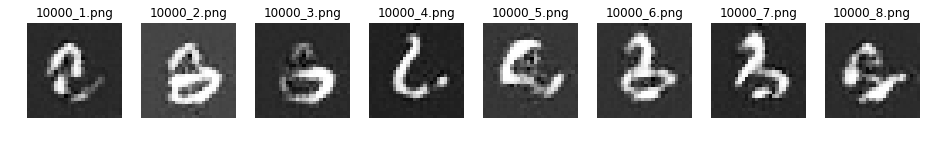

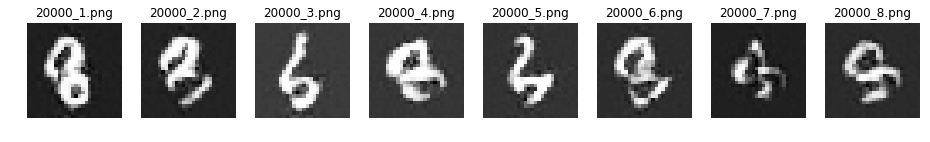

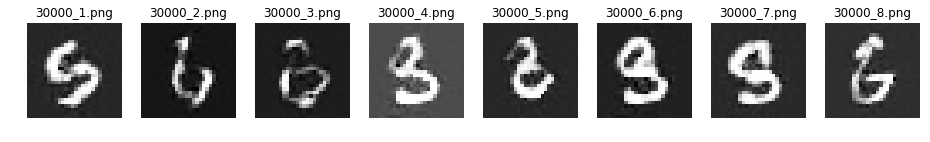

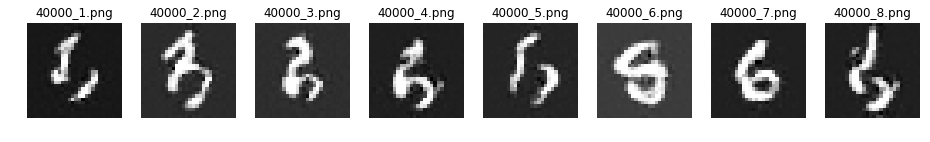

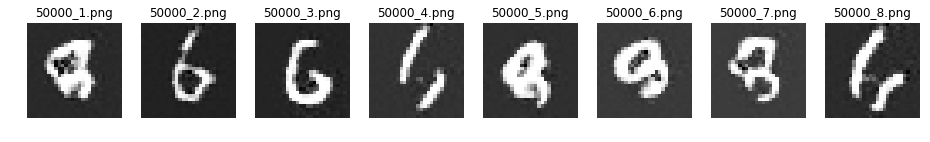

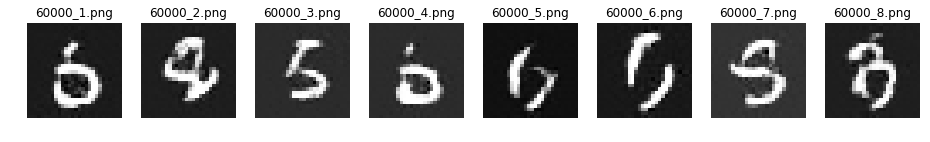

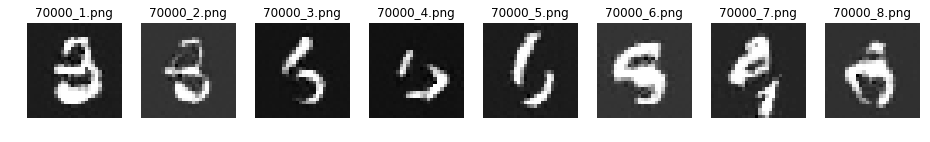

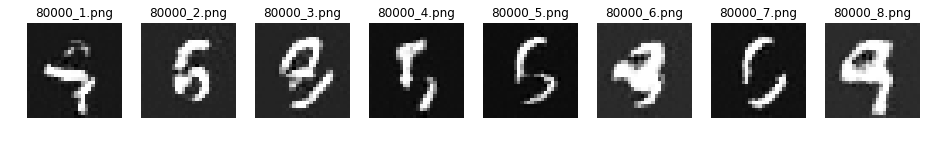

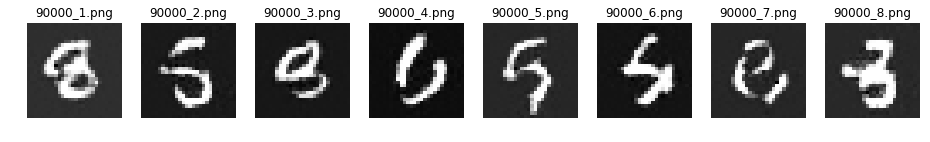

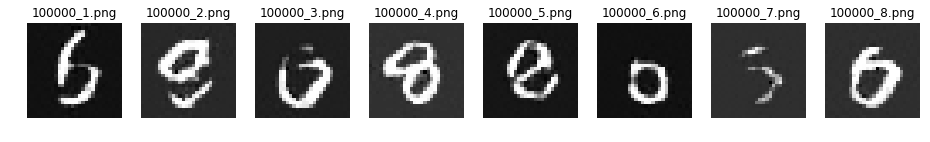

In [8]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

for step in range(100000):
    z = generate_z(batch_size, 100)
    X, _ = mnist.train.next_batch(batch_size)
    X = X.reshape(-1, 28, 28, 1)

    # discriminator 학습
    sess.run(opt_D, feed_dict={X_: X, z_: z, is_training: True})

    sess.run(opt_G, feed_dict={X_: X, z_: z, is_training: True})
    # generator 학습 (discriminator 1번 당 generator를 2번 학습시키면 결과가 조금 더 좋음)
    sess.run(opt_G, feed_dict={X_: X, z_: z, is_training: True})
        
    # 샘플 결과 확인
    if (step+1) % 10000 == 0:
        print(step+1, "step done.")
        
        z = generate_z(8, 100)
        gen = sess.run(G, feed_dict={z_: z, is_training: False})
        gen = ((gen+1) / 2.0).reshape(-1, 28, 28)
        
        fig = plt.figure(figsize=(16, 16))
        for i, img in enumerate(gen):
            title = "{}_{}.png".format(step+1, i+1)
            a = fig.add_subplot(1, 8, i+1)
            a.axis("off")
            a.set_title(title)
            plt.imshow(img, cmap="gray")
            plt.imsave(os.path.join(sample_dir, title), img, cmap="gray")

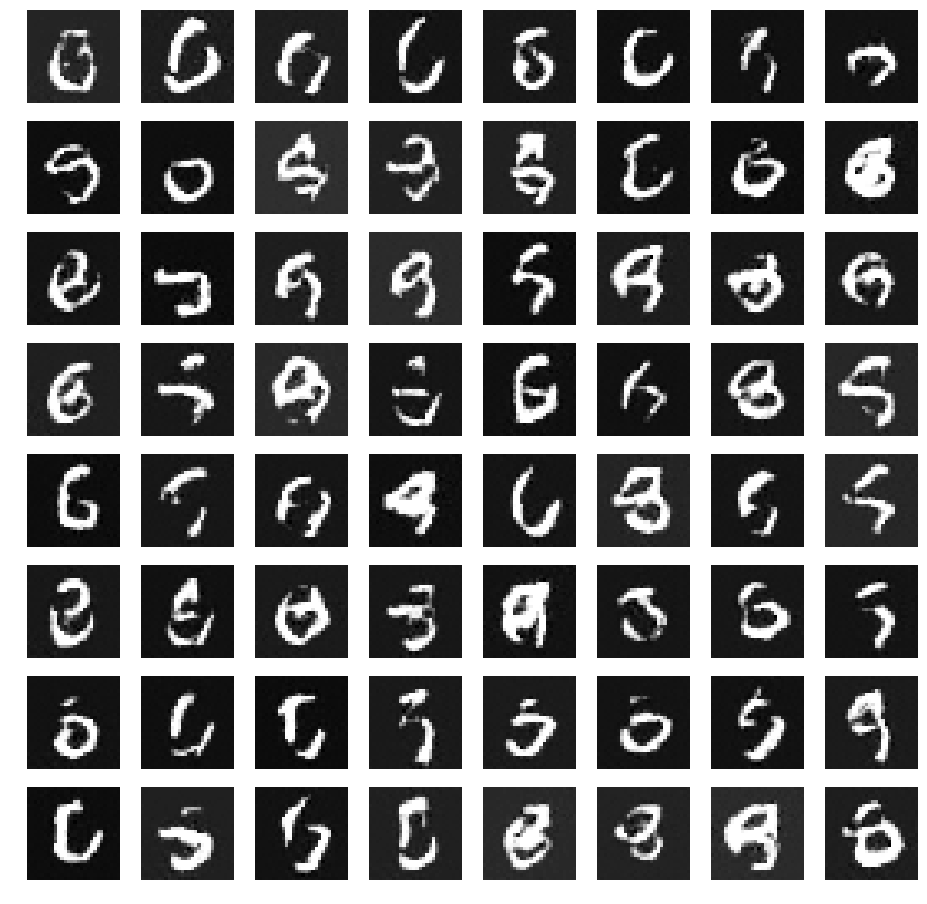

In [16]:
z = generate_z(64, 100)
gen = sess.run(G, feed_dict={z_: z, is_training: False})
gen = ((gen+1) / 2.0).reshape(-1, 28, 28)

fig = plt.figure(figsize=(16, 16))
for i, img in enumerate(gen):
    a = fig.add_subplot(8, 8, i+1)
    a.axis("off")
    plt.imshow(img, cmap="gray")